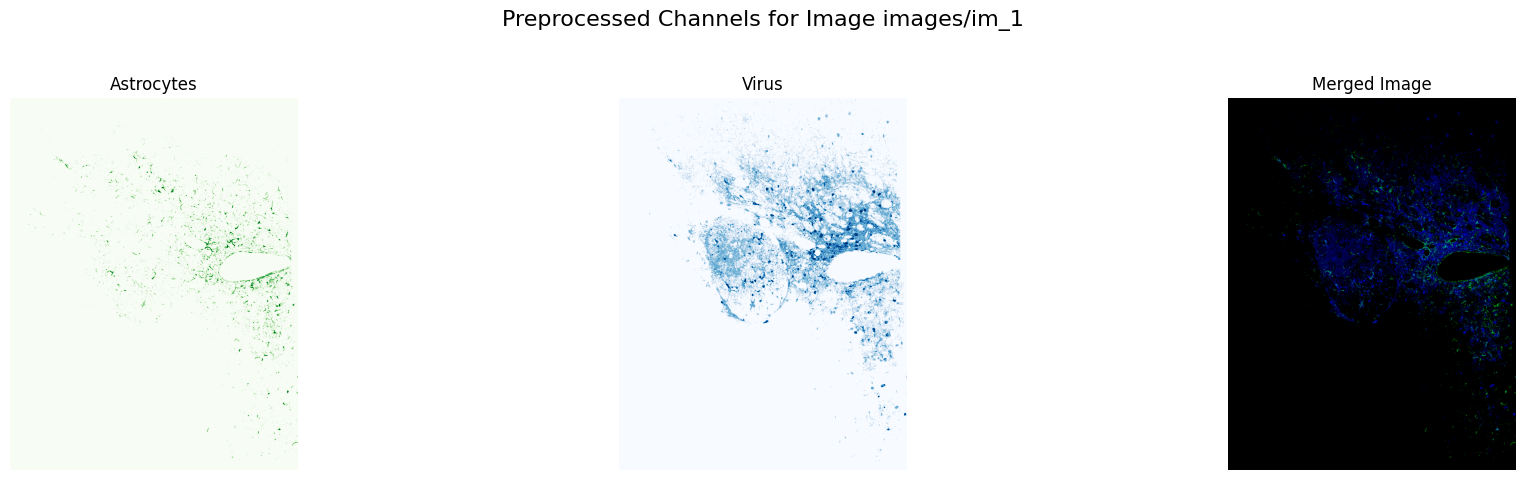

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu
import pandas as pd

# Function to apply 3-class Otsu thresholding


def apply_otsu_threshold(image):
    thresholds = threshold_multiotsu(image, classes=3)
    regions = np.digitize(image, bins=thresholds)
    return regions


# Define the image path
image_path = 'images/im_1'

# Load image channels (green, blue, red)
cell_img = cv2.imread(os.path.join(
    image_path, 'cell.jpg'), cv2.IMREAD_GRAYSCALE)
marker_img = cv2.imread(os.path.join(
    image_path, 'marker.jpg'), cv2.IMREAD_GRAYSCALE)

# Check if any of the images failed to load
if cell_img is None or marker_img is None:
    raise FileNotFoundError(
        "One or more image channels could not be loaded. Please check the image paths.")

# Apply 3-class Otsu thresholding to each channel
cell_otsu = apply_otsu_threshold(cell_img)
marker_otsu = apply_otsu_threshold(marker_img)


# Merge channels to create a combined RGB image
merged_image = cv2.merge([cell_img, cell_img, marker_img])

# Create a color image from the thresholded channels
thresholded_rgb_image = np.zeros_like(merged_image)
thresholded_rgb_image[..., 0] = cell_otsu * 0     # Red channel
thresholded_rgb_image[..., 1] = cell_otsu * 85     # Green channel
thresholded_rgb_image[..., 2] = marker_otsu * 85   # Blue channel

# Plot the thresholded images side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f'Preprocessed Channels for Image {image_path}', fontsize=16)

# Thresholded images
axes[0].imshow(cell_otsu, cmap='Greens')
axes[0].set_title('Astrocytes')
axes[1].imshow(marker_otsu, cmap='Blues')
axes[1].set_title('Virus')
axes[2].imshow(thresholded_rgb_image)
axes[2].set_title('Merged Image')

# Hide axes
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plotted image
#plt.savefig(os.path.join(image_path, 'overview.png'))

In [2]:
virus_mean_all = (marker_otsu > 0).mean().round(4)*100
astro_mean_all = (cell_otsu > 0).mean().round(4)*100
virus_mean_all_to_astro_mean_all = (virus_mean_all/astro_mean_all).round(2)
print(f"Virus Pixel Coverage (pixel % > 0): {virus_mean_all} %")
print(f"Astrocytes Pixel Coverage (pixel % > 0): {astro_mean_all} %")
print(f"Astro to Virus % Ratio: {virus_mean_all_to_astro_mean_all} %")

Virus Pixel Coverage (pixel % > 0): 11.58 %
Astrocytes Pixel Coverage (pixel % > 0): 2.3 %
Astro to Virus % Ratio: 5.03 %


In [40]:
import seaborn as sns
def img_to_df(img):
    # Get image dimensions
    height, width = img.shape

    # Generate all x and y coordinates
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten coordinates and get the values from the image
    x_flat = x_coords.flatten()
    y_flat = y_coords.flatten()
    values_flat = (img.flatten() > 0).astype(int)  # Convert to 0/1 based on the condition

    # Create the DataFrame
    df = pd.DataFrame({'x': x_flat, 'y': y_flat, 'value': values_flat})

    return df

df = img_to_df(marker_otsu)


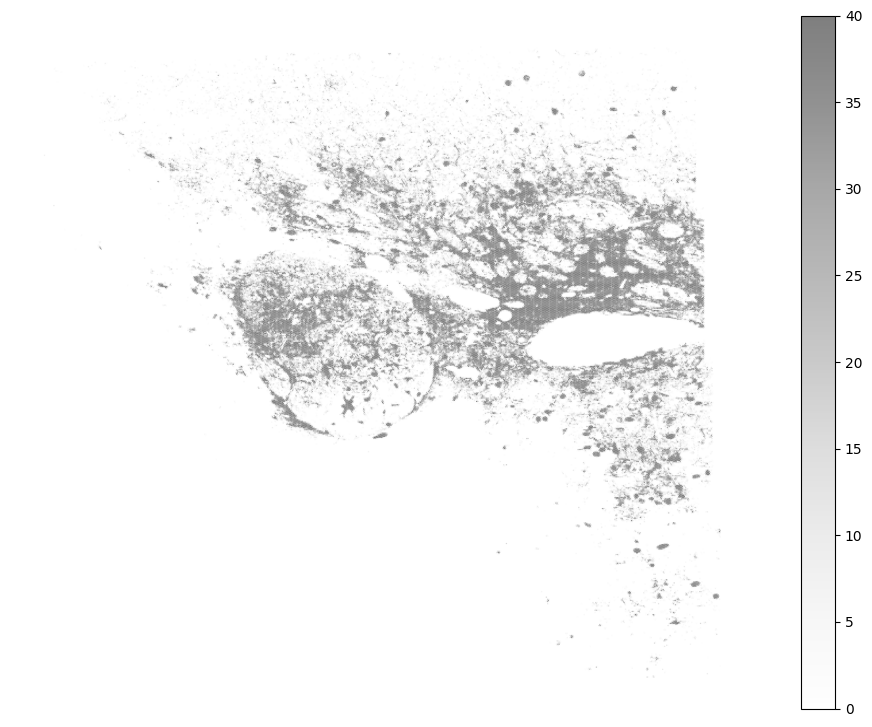

In [41]:
import matplotlib.pyplot as plt

# Filter out only non-zero pixels to focus on areas of interest
df_filtered = df[df["value"] > 0]

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

# Generate and add hexbin with 50 hexagons in each dimension, no borderlines,
# half transparency, and the reverse viridis colormap
hb = ax.hexbin(
    df_filtered["x"],
    df_filtered["y"],
    gridsize=500,
    linewidths=0,
    alpha=0.5,
    cmap="Greys"
)

# Add colorbar
plt.colorbar(hb)

# Remove axes
ax.set_axis_off()

# Invert y-axis to match image orientation
ax.invert_yaxis()

# Show the plot
plt.show()


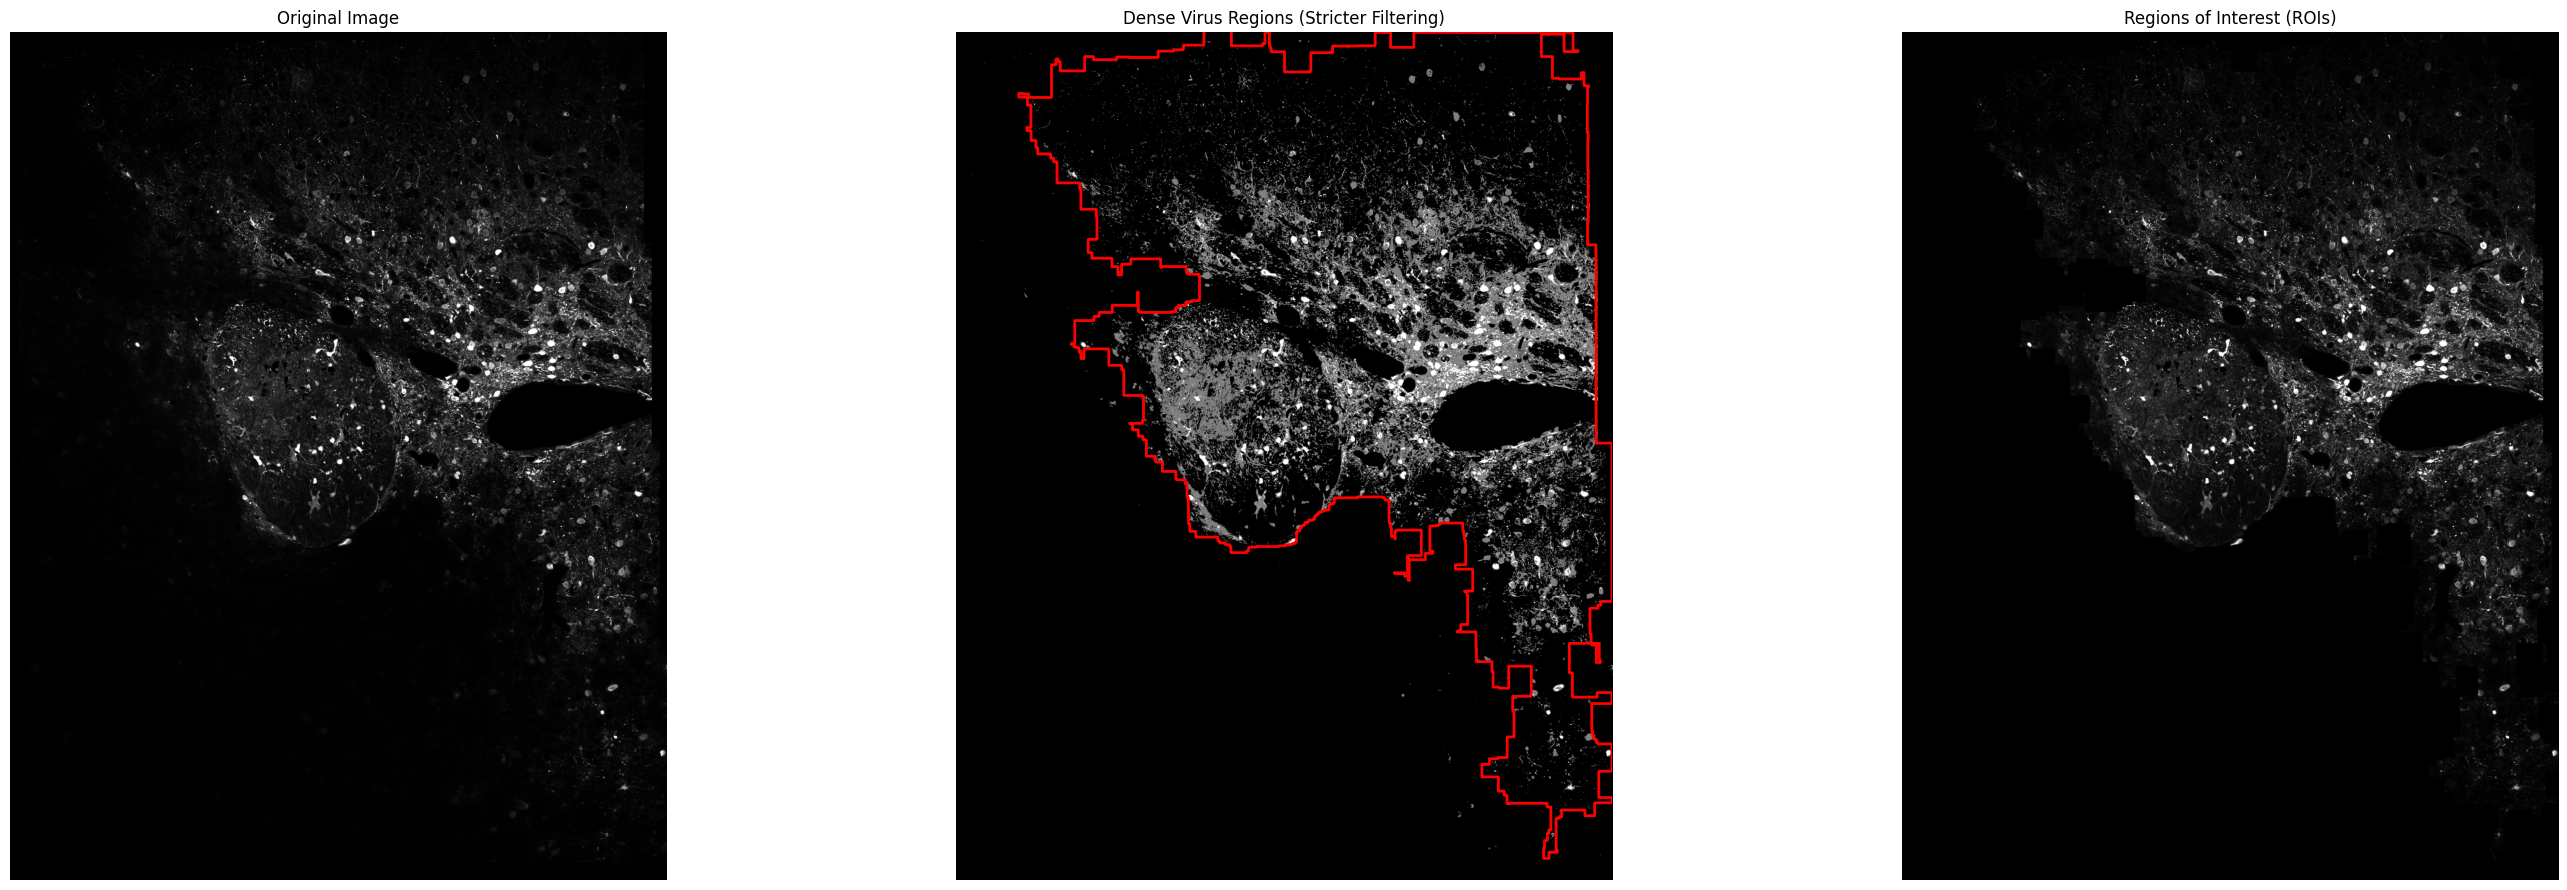

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_dense_regions(marker_img, marker_otsu):
    # Step 1: Threshold the image to create a binary mask
    binary_img = np.where(marker_otsu > 0, 255, 0).astype(np.uint8)
    
    # Step 2: Apply morphological operations to fill small holes and join nearby areas
    kernel_close = np.ones((90, 90), np.uint8)  # Larger kernel for stricter closing
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # Apply erosion to separate less dense regions
    kernel_erode = np.ones((10, 10), np.uint8)  # Kernel for erosion to refine dense areas
    eroded_img = cv2.erode(closed_img, kernel_erode)

    # Step 3: Find contours in the eroded image
    contours, _ = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Create a mask from the contours
    mask = np.zeros_like(marker_img, dtype=np.uint8)
    for contour in contours:
        if cv2.contourArea(contour) > 20000:  # Increase the area threshold for stricter filtering
            cv2.drawContours(mask, [contour], -1, color=255, thickness=cv2.FILLED)

    # Step 5: Apply the mask to the original image to keep only ROIs
    roi_img = cv2.bitwise_and(marker_img, marker_img, mask=mask)

    # Step 6: Set up plot with side-by-side comparison
    fig, axes = plt.subplots(1, 3, figsize=(30, 9))

    # Original image on the left
    axes[0].imshow(marker_img, cmap='gray')
    axes[0].set_title('Raw')
    axes[0].axis('off')

    # Contour image in the middle
    axes[1].imshow(marker_otsu, cmap='gray')
    for contour in contours:
        if cv2.contourArea(contour) > 20000:  # Increase the area threshold for stricter filtering
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[1].plot(x, y, color='red', linewidth=2)  # Draw contour perimeter in red

    axes[1].set_title('Dense Virus Regions (Otsu Contouring)')
    axes[1].axis('off')

    # Masked ROI image on the right
    axes[2].imshow(roi_img, cmap='gray')
    axes[2].set_title('Regions of Interest (Raw Masked)')
    axes[2].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

    return mask

mask = plot_dense_regions(marker_img, marker_otsu)

# Save the mask if needed
#cv2.imwrite("dense_regions_mask.png", mask)


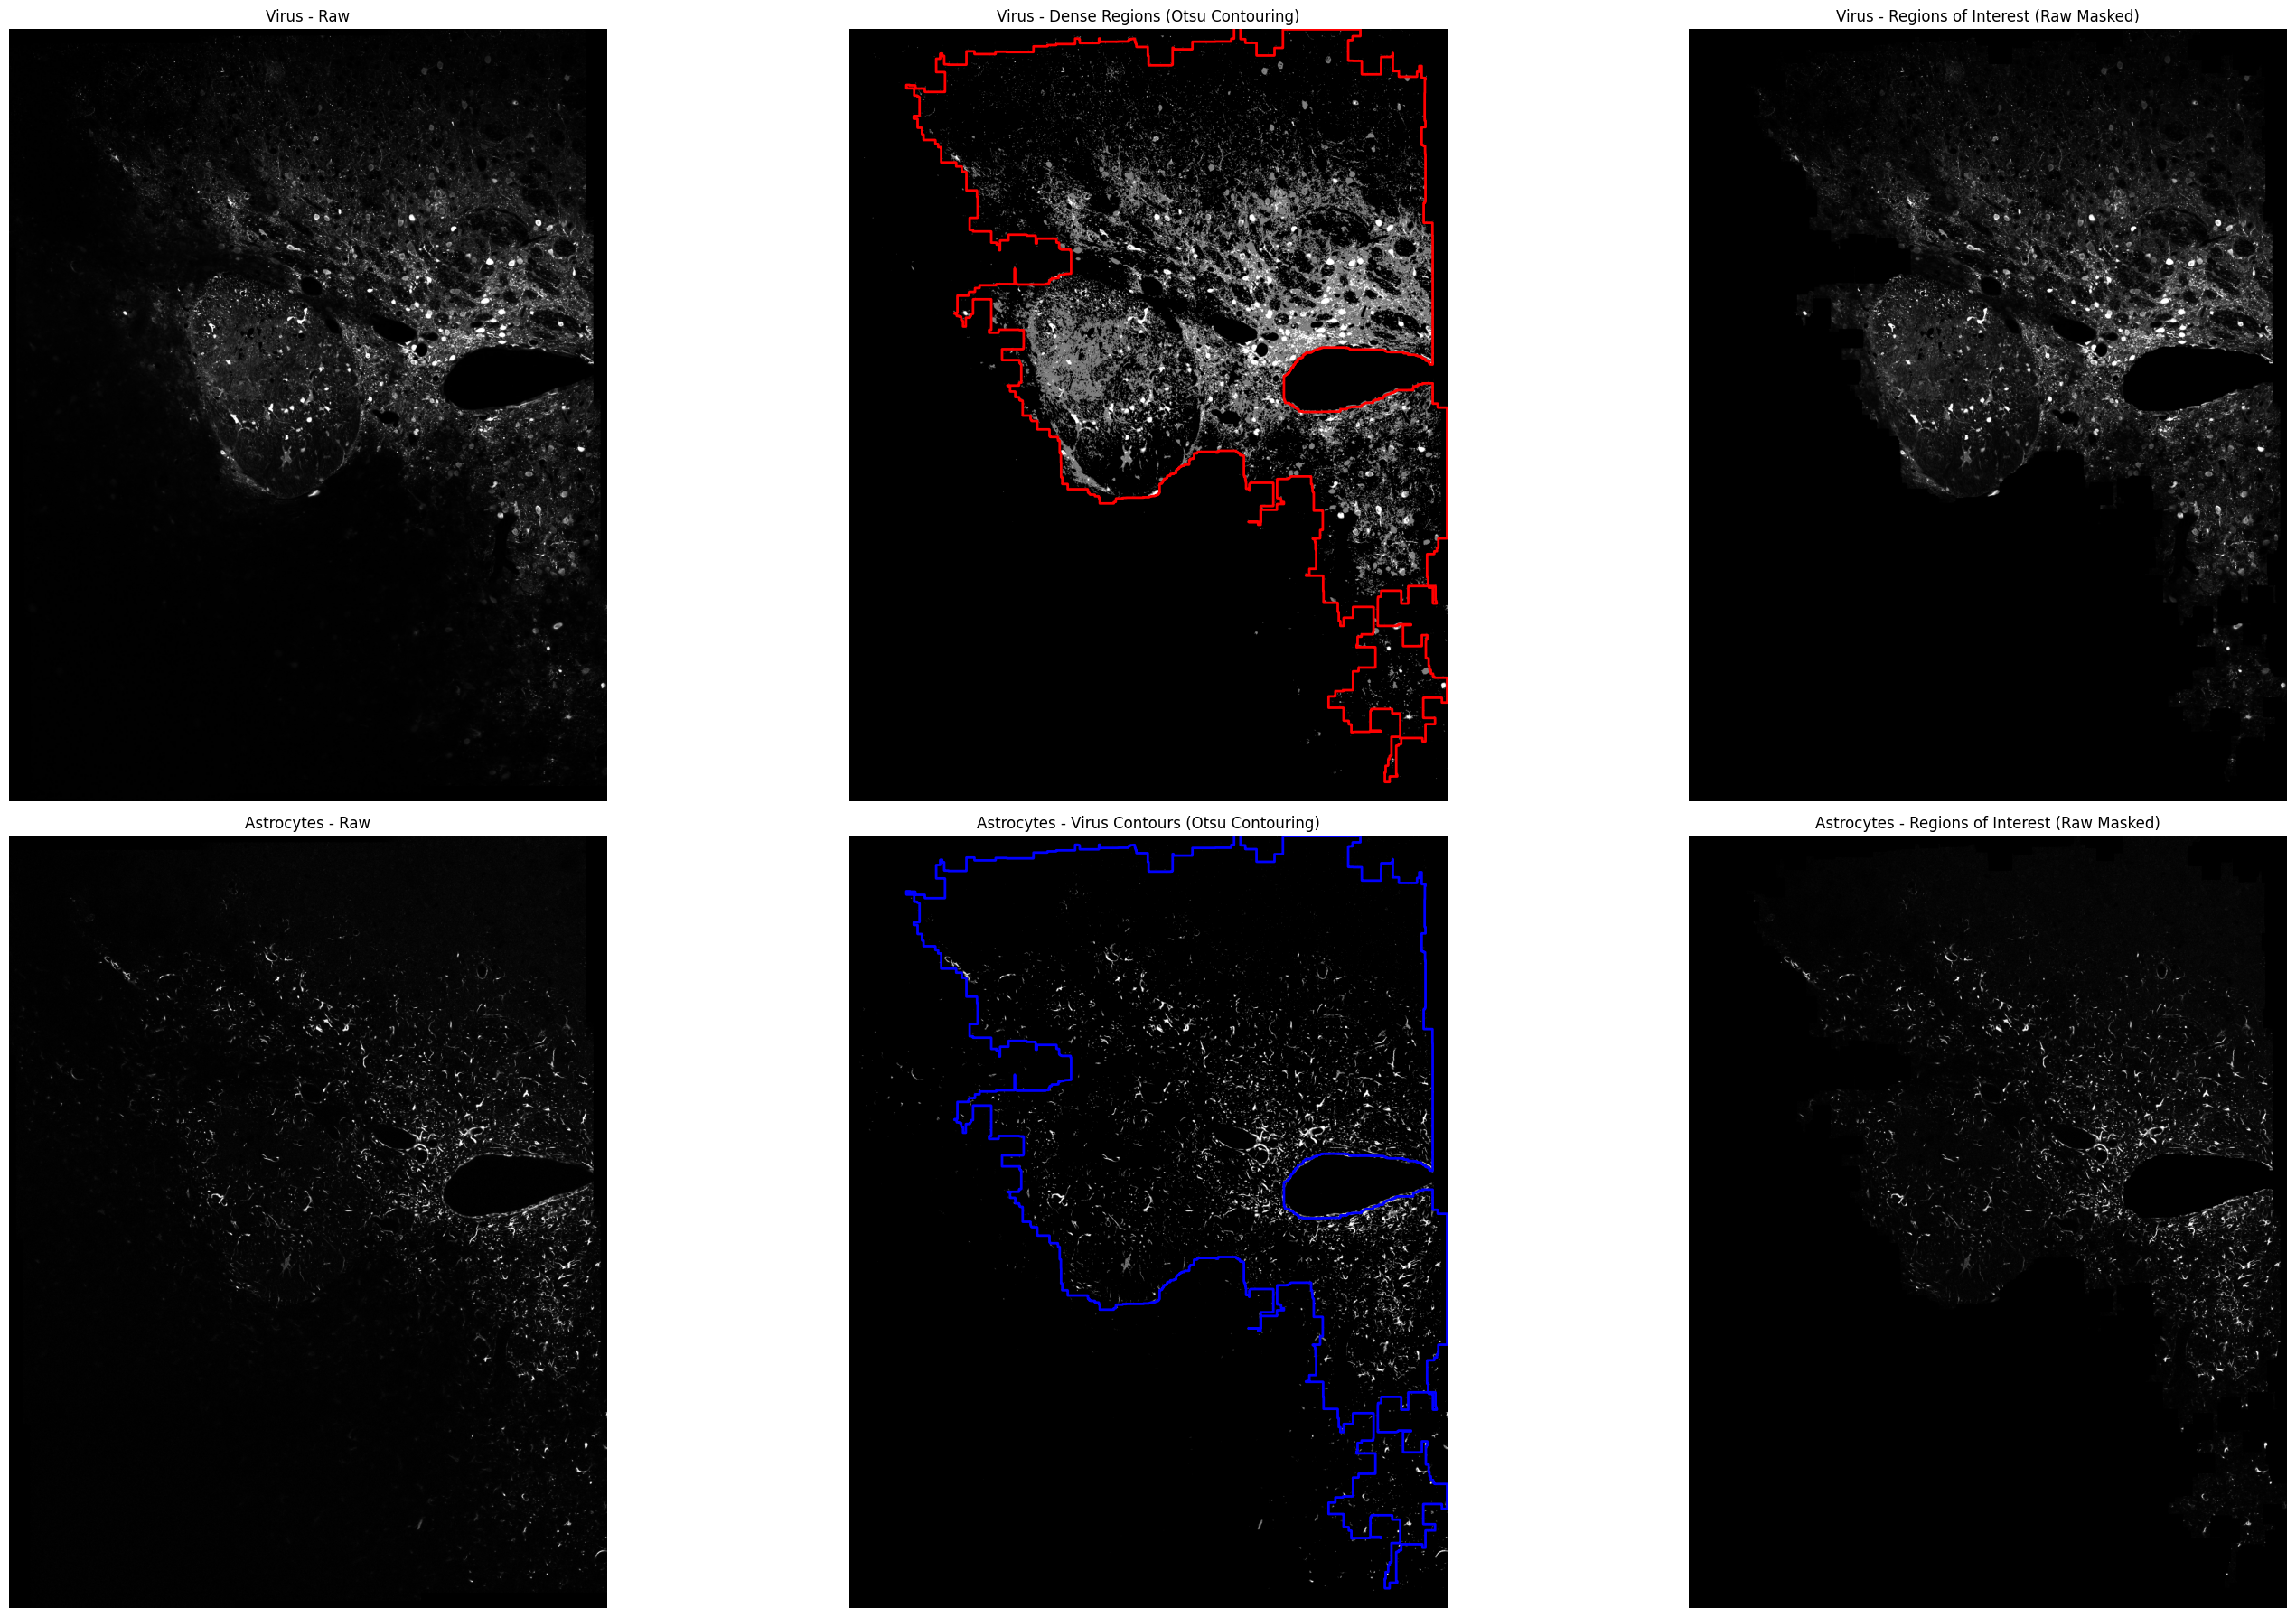

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_dense_regions(marker_img, marker_otsu, cell_img, cell_otsu):
    # Step 1: Threshold the image to create a binary mask for viruses
    binary_img = np.where(marker_otsu > 0, 255, 0).astype(np.uint8)
    
    # Step 2: Apply morphological operations to fill small holes and join nearby areas
    kernel_close = np.ones((80, 80), np.uint8)  # Larger kernel for stricter closing
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # Apply erosion to separate less dense regions
    kernel_erode = np.ones((10, 10), np.uint8)  # Kernel for erosion to refine dense areas
    eroded_img = cv2.erode(closed_img, kernel_erode)

    # Step 3: Find contours in the eroded image
    contours, _ = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Create a mask from the contours
    mask = np.zeros_like(marker_img, dtype=np.uint8)
    for contour in contours:
        if cv2.contourArea(contour) > 20000:  # Increase the area threshold for stricter filtering
            cv2.drawContours(mask, [contour], -1, color=255, thickness=cv2.FILLED)

    # Step 5: Apply the mask to the original virus image to keep only ROIs
    roi_img_virus = cv2.bitwise_and(marker_img, marker_img, mask=mask)

    # Step 6: Set up plot with side-by-side comparison for the virus and astrocytes
    fig, axes = plt.subplots(2, 3, figsize=(30, 18))

    # Virus Images Plotting
    # Original virus image on the left
    axes[0, 0].imshow(marker_img, cmap='gray')
    axes[0, 0].set_title('Virus - Raw')
    axes[0, 0].axis('off')

    # Virus image with contours in the middle
    axes[0, 1].imshow(marker_otsu, cmap='gray')
    for contour in contours:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[0, 1].plot(x, y, color='red', linewidth=2)  # Draw contour perimeter in red

    axes[0, 1].set_title('Virus - Dense Regions (Otsu Contouring)')
    axes[0, 1].axis('off')

    # Virus masked ROI image on the right
    axes[0, 2].imshow(roi_img_virus, cmap='gray')
    axes[0, 2].set_title('Virus - Regions of Interest (Raw Masked)')
    axes[0, 2].axis('off')

    # Astrocyte Images Plotting
    # Original astrocyte image on the left
    axes[1, 0].imshow(cell_img, cmap='gray')
    axes[1, 0].set_title('Astrocytes - Raw')
    axes[1, 0].axis('off')

    # Astrocyte image with virus contours in the middle
    axes[1, 1].imshow(cell_otsu, cmap='gray')
    for contour in contours:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[1, 1].plot(x, y, color='blue', linewidth=2)  # Draw virus contour perimeter in blue

    axes[1, 1].set_title('Astrocytes - Virus Contours (Otsu Contouring)')
    axes[1, 1].axis('off')

    # Apply the virus mask to the astrocyte image to keep only ROIs
    roi_img_astrocytes = cv2.bitwise_and(cell_img, cell_img, mask=mask)
    axes[1, 2].imshow(roi_img_astrocytes, cmap='gray')
    axes[1, 2].set_title('Astrocytes - Regions of Interest (Raw Masked)')
    axes[1, 2].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()

    return mask, contours


virus_mask, virus_contours = plot_dense_regions(marker_img, marker_otsu, cell_img, cell_otsu)

# # Save the mask and contours if needed
# cv2.imwrite("virus_dense_regions_mask.png", virus_mask)
# for i, contour in enumerate(virus_contours):
#     if cv2.contourArea(contour) > 20000:
#         contour_img = np.zeros_like(marker_img, dtype=np.uint8)
#         cv2.drawContours(contour_img, [contour], -1, color=255, thickness=cv2.FILLED)
#         cv2.imwrite(f"virus_contour_{i}.png", contour_img)


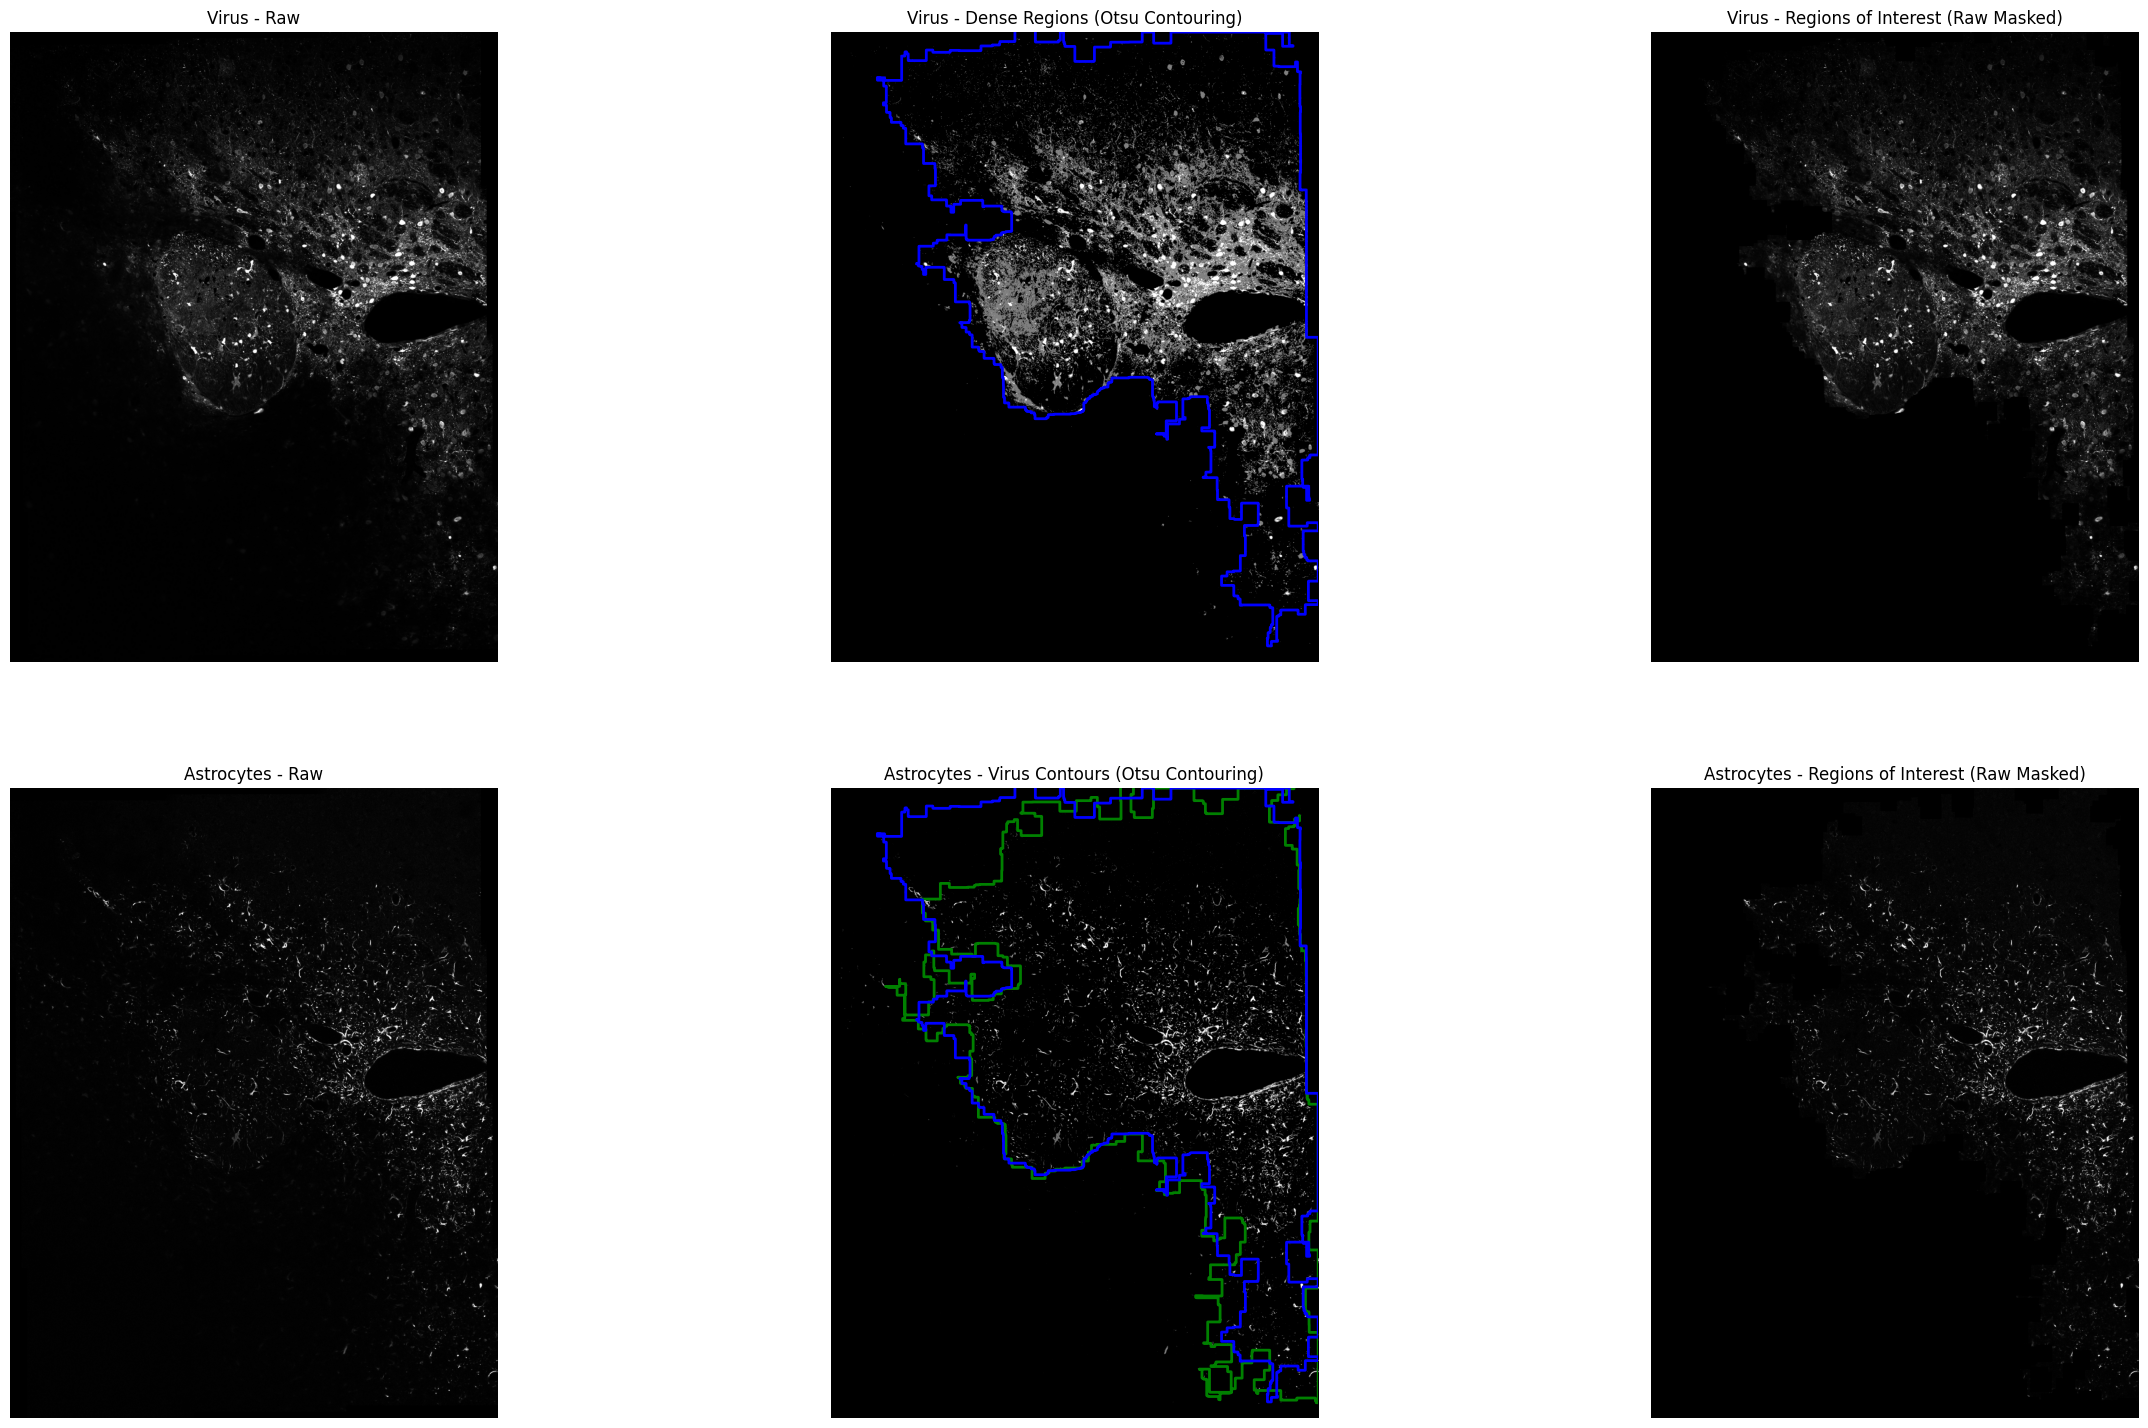

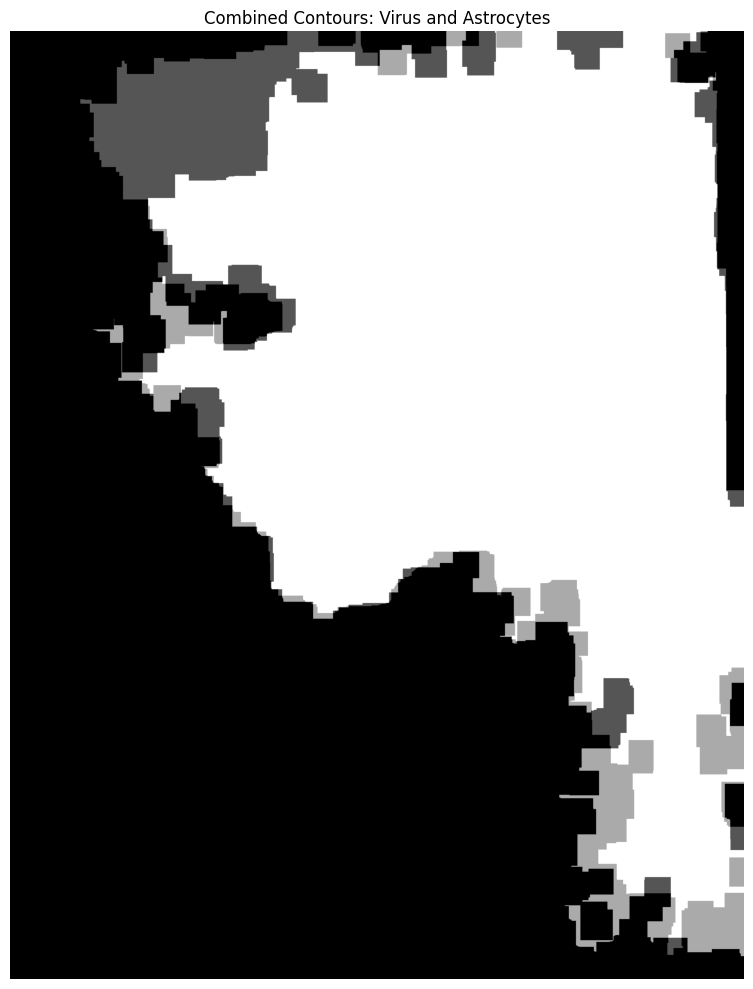

Virus Contour Perimeter: 19351.26
Virus Contour Area: 5468471.00
Astrocytes Contour Perimeter: 22262.63
Astrocytes Contour Area: 5254178.00
Intersection Area: 4864604.00
Virus Pixel Coverage (pixel % > 0): 11.58 %
Astrocytes Pixel Coverage (pixel % > 0): 2.3 %
Astro to Virus % Ratio: 5.03 %


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_dense_regions(marker_img, marker_otsu, cell_img, cell_otsu):
    # Step 1: Threshold the image to create binary masks for viruses and astrocytes
    binary_virus = np.where(marker_otsu > 0, 255, 0).astype(np.uint8)
    binary_astrocytes = np.where(cell_otsu > 0, 255, 0).astype(np.uint8)
    
    # Step 2: Apply morphological operations for viruses
    kernel_close = np.ones((90, 90), np.uint8)  # Larger kernel for stricter closing
    closed_virus = cv2.morphologyEx(binary_virus, cv2.MORPH_CLOSE, kernel_close)
    kernel_erode = np.ones((10, 10), np.uint8)
    eroded_virus = cv2.erode(closed_virus, kernel_erode)
    
    # Step 2: Apply morphological operations for astrocytes
    closed_astrocytes = cv2.morphologyEx(binary_astrocytes, cv2.MORPH_CLOSE, kernel_close)
    eroded_astrocytes = cv2.erode(closed_astrocytes, kernel_erode)

    # Step 3: Find contours in the eroded images
    contours_virus, _ = cv2.findContours(eroded_virus, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_astrocytes, _ = cv2.findContours(eroded_astrocytes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Create masks from the contours
    virus_mask = np.zeros_like(marker_img, dtype=np.uint8)
    for contour in contours_virus:
        if cv2.contourArea(contour) > 20000:
            cv2.drawContours(virus_mask, [contour], -1, color=255, thickness=cv2.FILLED)

    astrocyte_mask = np.zeros_like(cell_img, dtype=np.uint8)
    for contour in contours_astrocytes:
        if cv2.contourArea(contour) > 20000:
            cv2.drawContours(astrocyte_mask, [contour], -1, color=255, thickness=cv2.FILLED)

    # Step 5: Apply the masks to the original images
    roi_img_virus = cv2.bitwise_and(marker_img, marker_img, mask=virus_mask)
    roi_img_astrocytes = cv2.bitwise_and(cell_img, cell_img, mask=astrocyte_mask)

    # Step 6: Set up plot with side-by-side comparison for virus and astrocytes
    fig, axes = plt.subplots(2, 3, figsize=(30, 18))

    # Virus images plotting
    axes[0, 0].imshow(marker_img, cmap='gray')
    axes[0, 0].set_title('Virus - Raw')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(marker_otsu, cmap='gray')
    for contour in contours_virus:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[0, 1].plot(x, y, color='blue', linewidth=2)  # Draw virus contour in blue
    axes[0, 1].set_title('Virus - Dense Regions (Otsu Contouring)')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(roi_img_virus, cmap='gray')
    axes[0, 2].set_title('Virus - Regions of Interest (Raw Masked)')
    axes[0, 2].axis('off')

    # Astrocytes images plotting
    axes[1, 0].imshow(cell_img, cmap='gray')
    axes[1, 0].set_title('Astrocytes - Raw')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(cell_otsu, cmap='gray')
    for contour in contours_astrocytes:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[1, 1].plot(x, y, color='green', linewidth=2)  # Draw astrocyte contour in green
    for contour in contours_virus:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[1, 1].plot(x, y, color='blue', linewidth=2)  # Draw virus contour in blue
    axes[1, 1].set_title('Astrocytes - Virus Contours (Otsu Contouring)')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(roi_img_astrocytes, cmap='gray')
    axes[1, 2].set_title('Astrocytes - Regions of Interest (Raw Masked)')
    axes[1, 2].axis('off')

    # Step 7: Calculate intersection and final combined visualization
    combined_mask = np.zeros_like(marker_img, dtype=np.uint8)
    combined_mask[virus_mask == 255] = 50  # Light blue for virus only
    combined_mask[astrocyte_mask == 255] = 100  # Light green for astrocyte only
    combined_mask[(virus_mask == 255) & (astrocyte_mask == 255)] = 150  # Yellow for intersection

    fig_combined, ax_combined = plt.subplots(figsize=(15, 10))
    ax_combined.imshow(combined_mask, cmap='gray')
    ax_combined.set_title('Combined Contours: Virus and Astrocytes')
    ax_combined.axis('off')
    plt.tight_layout()
    plt.show()

    # Step 8: Calculate perimeters and areas
    perimeter_virus = sum(cv2.arcLength(contour, True) for contour in contours_virus if cv2.contourArea(contour) > 20000)
    area_virus = sum(cv2.contourArea(contour) for contour in contours_virus if cv2.contourArea(contour) > 20000)
    perimeter_astrocytes = sum(cv2.arcLength(contour, True) for contour in contours_astrocytes if cv2.contourArea(contour) > 20000)
    area_astrocytes = sum(cv2.contourArea(contour) for contour in contours_astrocytes if cv2.contourArea(contour) > 20000)
    area_intersection = np.sum((virus_mask == 255) & (astrocyte_mask == 255))

    print(f"Virus Contour Perimeter: {perimeter_virus:.2f}")
    print(f"Virus Contour Area: {area_virus:.2f}")
    print(f"Astrocytes Contour Perimeter: {perimeter_astrocytes:.2f}")
    print(f"Astrocytes Contour Area: {area_astrocytes:.2f}")
    print(f"Intersection Area: {area_intersection:.2f}")

    # Step 9: Calculate pixel coverage stats after applying the virus mask on both
    virus_mean_all = (marker_otsu > 0).mean().round(4) * 100
    astro_mean_all = (cell_otsu > 0).mean().round(4) * 100
    virus_mean_all_to_astro_mean_all = (virus_mean_all / astro_mean_all).round(2)

    print(f"Virus Pixel Coverage (pixel % > 0): {virus_mean_all} %")
    print(f"Astrocytes Pixel Coverage (pixel % > 0): {astro_mean_all} %")
    print(f"Astro to Virus % Ratio: {virus_mean_all_to_astro_mean_all} %")

# Example usage

plot_dense_regions(marker_img, marker_otsu, cell_img, cell_otsu)


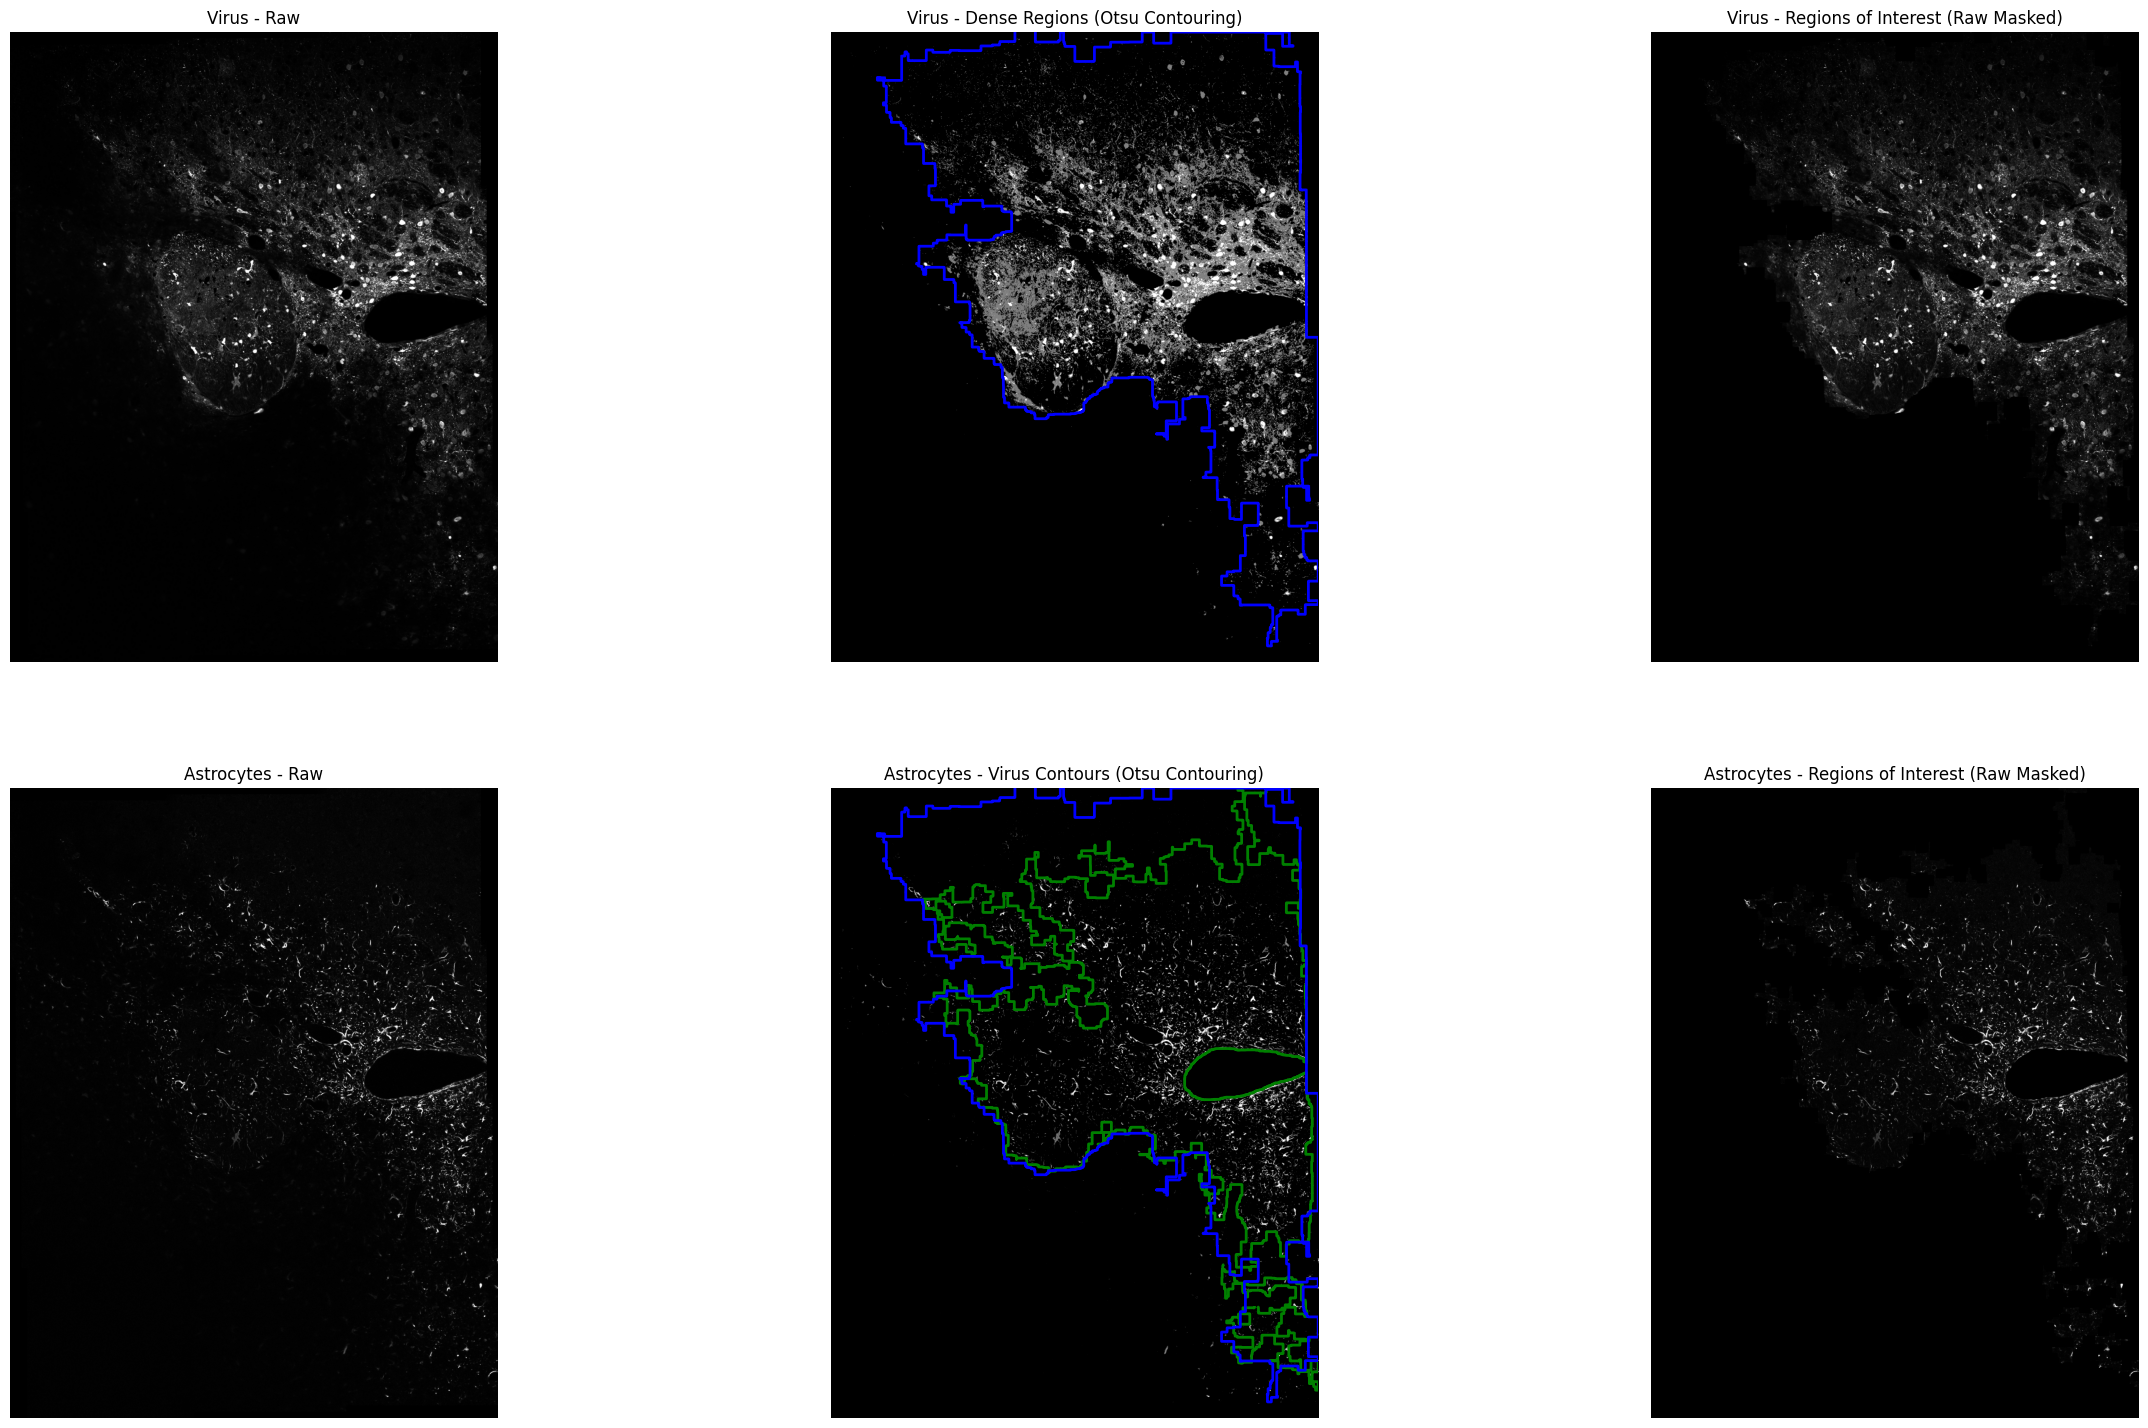

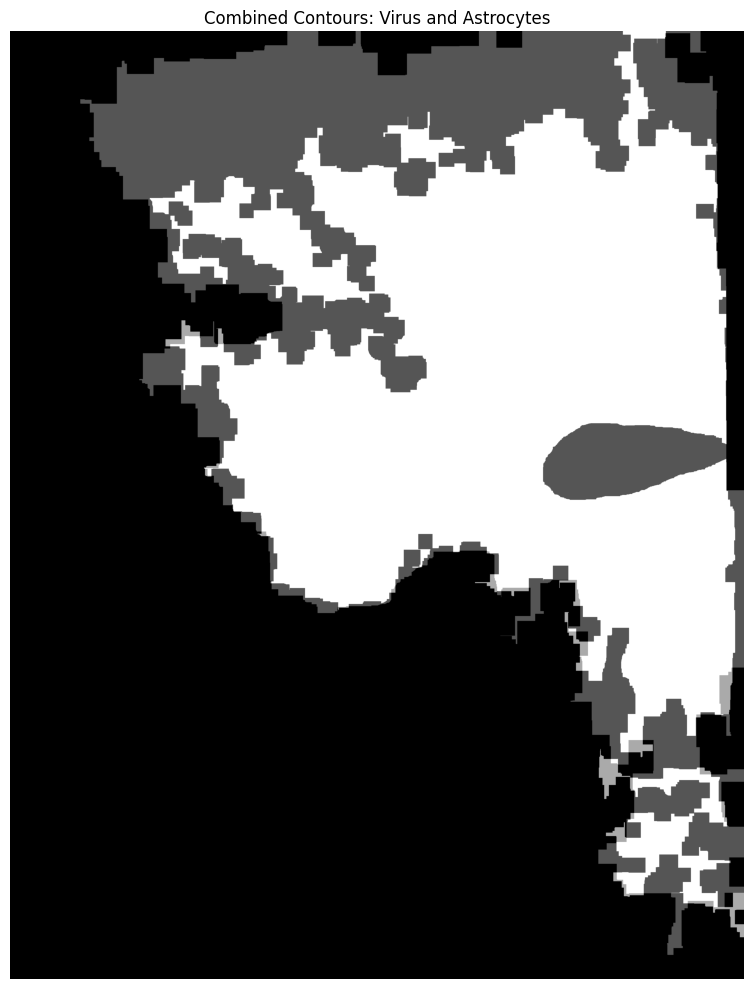

Virus Contour Perimeter: 19351.26
Virus Contour Area: 5468471.00
Astrocytes Contour Perimeter: 34900.35
Astrocytes Contour Area: 3484200.50
Intersection Area: 3445473.00
Virus Pixel Coverage in Masked Area (pixel % > 0): 11.52 %
Astrocytes Pixel Coverage in Masked Area (pixel % > 0): 2.22 %
Astro to Virus % Ratio in Masked Area: 5.19 %


In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_multiotsu
import pandas as pd

# Function to apply 3-class Otsu thresholding


def apply_otsu_threshold(image):
    thresholds = threshold_multiotsu(image, classes=3)
    regions = np.digitize(image, bins=thresholds)
    return regions


# Define the image path
image_path = 'images/im_1'

# Load image channels (green, blue, red)
cell_img = cv2.imread(os.path.join(
    image_path, 'cell.jpg'), cv2.IMREAD_GRAYSCALE)
marker_img = cv2.imread(os.path.join(
    image_path, 'marker.jpg'), cv2.IMREAD_GRAYSCALE)

# Check if any of the images failed to load
if cell_img is None or marker_img is None:
    raise FileNotFoundError(
        "One or more image channels could not be loaded. Please check the image paths.")

# Apply 3-class Otsu thresholding to each channel
cell_otsu = apply_otsu_threshold(cell_img)
marker_otsu = apply_otsu_threshold(marker_img)


# Merge channels to create a combined RGB image
merged_image = cv2.merge([cell_img, cell_img, marker_img])

# Create a color image from the thresholded channels
thresholded_rgb_image = np.zeros_like(merged_image)
thresholded_rgb_image[..., 0] = cell_otsu * 0     # Red channel
thresholded_rgb_image[..., 1] = cell_otsu * 85     # Green channel
thresholded_rgb_image[..., 2] = marker_otsu * 85   # Blue channel

# Plot the thresholded images side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f'Preprocessed Channels for Image {image_path}', fontsize=16)

# Thresholded images
axes[0].imshow(cell_otsu, cmap='Greens')
axes[0].set_title('Astrocytes')
axes[1].imshow(marker_otsu, cmap='Blues')
axes[1].set_title('Virus')
axes[2].imshow(thresholded_rgb_image)
axes[2].set_title('Merged Image')

# Hide axes
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Save the plotted image
#plt.savefig(os.path.join(image_path, 'overview.png'))


virus_mean_all = (marker_otsu > 0).mean().round(4)*100
astro_mean_all = (cell_otsu > 0).mean().round(4)*100
virus_mean_all_to_astro_mean_all = (virus_mean_all/astro_mean_all).round(2)
print(f"Virus Pixel Coverage (pixel % > 0): {virus_mean_all} %")
print(f"Astrocytes Pixel Coverage (pixel % > 0): {astro_mean_all} %")
print(f"Astro to Virus % Ratio: {virus_mean_all_to_astro_mean_all} %")


# Preprocessing function for different types of images (virus, astrocytes, etc.)
def preprocess_image(binary_img, kernel_close_size, kernel_erode_size, area_threshold):
    # Apply morphological operations
    kernel_close = np.ones((kernel_close_size, kernel_close_size), np.uint8)
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # Apply erosion to separate less dense regions
    kernel_erode = np.ones((kernel_erode_size, kernel_erode_size), np.uint8)
    eroded_img = cv2.erode(closed_img, kernel_erode)

    # Find contours in the eroded image
    contours, _ = cv2.findContours(eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask from the contours
    mask = np.zeros_like(binary_img, dtype=np.uint8)
    for contour in contours:
        if cv2.contourArea(contour) > area_threshold:  # Filter based on area threshold
            cv2.drawContours(mask, [contour], -1, color=255, thickness=cv2.FILLED)

    return mask, contours

def plot_dense_regions(marker_img, marker_otsu, cell_img, cell_otsu):
    # Step 1: Threshold the image to create binary masks for viruses and astrocytes
    binary_virus = np.where(marker_otsu > 0, 255, 0).astype(np.uint8)
    binary_astrocytes = np.where(cell_otsu > 0, 255, 0).astype(np.uint8)

    # Step 2: Preprocess virus and astrocyte images
    virus_mask, contours_virus = preprocess_image(binary_virus, kernel_close_size=90, kernel_erode_size=10, area_threshold=20000)
    astrocyte_mask, contours_astrocytes = preprocess_image(binary_astrocytes, kernel_close_size=50, kernel_erode_size=8, area_threshold=15000)

    # Step 3: Apply the masks to the original images
    roi_img_virus = cv2.bitwise_and(marker_img, marker_img, mask=virus_mask)
    roi_img_astrocytes = cv2.bitwise_and(cell_img, cell_img, mask=astrocyte_mask)

    # Step 4: Set up plot with side-by-side comparison for virus and astrocytes
    fig, axes = plt.subplots(2, 3, figsize=(30, 18))

    # Virus images plotting
    axes[0, 0].imshow(marker_img, cmap='gray')
    axes[0, 0].set_title('Virus - Raw')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(marker_otsu, cmap='gray')
    for contour in contours_virus:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[0, 1].plot(x, y, color='blue', linewidth=2)  # Draw virus contour in blue
    axes[0, 1].set_title('Virus - Dense Regions (Otsu Contouring)')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(roi_img_virus, cmap='gray')
    axes[0, 2].set_title('Virus - Regions of Interest (Raw Masked)')
    axes[0, 2].axis('off')

    # Astrocytes images plotting
    axes[1, 0].imshow(cell_img, cmap='gray')
    axes[1, 0].set_title('Astrocytes - Raw')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(cell_otsu, cmap='gray')
    for contour in contours_astrocytes:
        if cv2.contourArea(contour) > 15000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[1, 1].plot(x, y, color='green', linewidth=2)  # Draw astrocyte contour in green
    for contour in contours_virus:
        if cv2.contourArea(contour) > 20000:
            x, y = contour[:, 0, 0], contour[:, 0, 1]
            axes[1, 1].plot(x, y, color='blue', linewidth=2)  # Draw virus contour in blue
    axes[1, 1].set_title('Astrocytes - Virus Contours (Otsu Contouring)')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(roi_img_astrocytes, cmap='gray')
    axes[1, 2].set_title('Astrocytes - Regions of Interest (Raw Masked)')
    axes[1, 2].axis('off')

    # Step 5: Calculate intersection and final combined visualization
    combined_mask = np.zeros_like(marker_img, dtype=np.uint8)
    combined_mask[virus_mask == 255] = 50  # Light blue for virus only
    combined_mask[astrocyte_mask == 255] = 100  # Light green for astrocyte only
    combined_mask[(virus_mask == 255) & (astrocyte_mask == 255)] = 150  # Yellow for intersection

    fig_combined, ax_combined = plt.subplots(figsize=(15, 10))
    ax_combined.imshow(combined_mask, cmap='gray')
    ax_combined.set_title('Combined Contours: Virus and Astrocytes')
    ax_combined.axis('off')
    plt.tight_layout()
    plt.show()

    # Step 6: Calculate perimeters and areas
    perimeter_virus = sum(cv2.arcLength(contour, True) for contour in contours_virus if cv2.contourArea(contour) > 20000)
    area_virus = sum(cv2.contourArea(contour) for contour in contours_virus if cv2.contourArea(contour) > 20000)
    perimeter_astrocytes = sum(cv2.arcLength(contour, True) for contour in contours_astrocytes if cv2.contourArea(contour) > 15000)
    area_astrocytes = sum(cv2.contourArea(contour) for contour in contours_astrocytes if cv2.contourArea(contour) > 15000)
    area_intersection = np.sum((virus_mask == 255) & (astrocyte_mask == 255))

    print(f"Virus Contour Perimeter: {perimeter_virus:.2f}")
    print(f"Virus Contour Area: {area_virus:.2f}")
    print(f"Astrocytes Contour Perimeter: {perimeter_astrocytes:.2f}")
    print(f"Astrocytes Contour Area: {area_astrocytes:.2f}")
    print(f"Intersection Area: {area_intersection:.2f}")

    # Step 7: Calculate pixel coverage stats in masked areas (virus mask applied)
    masked_marker_otsu = cv2.bitwise_and(marker_otsu, marker_otsu, mask=virus_mask)
    masked_cell_otsu = cv2.bitwise_and(cell_otsu, cell_otsu, mask=virus_mask)

    virus_mean_masked = (masked_marker_otsu > 0).mean().round(4) * 100
    astro_mean_masked = (masked_cell_otsu > 0).mean().round(4) * 100
    virus_to_astro_ratio_masked = (virus_mean_masked / astro_mean_masked).round(2)

    print(f"Virus Pixel Coverage in Masked Area (pixel % > 0): {virus_mean_masked} %")
    print(f"Astrocytes Pixel Coverage in Masked Area (pixel % > 0): {astro_mean_masked} %")
    print(f"Astro to Virus % Ratio in Masked Area: {virus_to_astro_ratio_masked} %")
    
plot_dense_regions(marker_img, marker_otsu, cell_img, cell_otsu)
